# Legal text classifcation with JRC dataset and fastai

Like all notebooks in the JRC series, the dataset used it the JRC-Acquis dataset.

For all infos about the dataset and its features, and the methods used there, and also for an extensive evaluation see our paper: https://aic.ai.wu.ac.at/~polleres/publications/filt-etal-2019COOPIS.pdf

The problem tackled here is **large-scale multi-label text classification** (LMTC). The characteristics of this dataset are: about 20K documents labelled with about 4K labels, with a long-tail (power-law) label distribution. So one could say it's a very hard problem.

**Citation:**
```
@inproceedings{filtz2019exploiting,
  title={Exploiting EuroVoc’s Hierarchical Structure for Classifying Legal Documents},
  author={Filtz, Erwin and Kirrane, Sabrina and Polleres, Axel and Wohlgenannt, Gerhard},
  booktitle={OTM Confederated International Conferences" On the Move to Meaningful Internet Systems"},
  pages={164--181},
  year={2019},
  organization={Springer}
}
```

In this notebook, we train / fine-tune the `AWD_LSTM` classifier on the JRC-Acquis dataset with fastAI.

Settings:
* **with proprocessing** -- we applied our own preprocessing pipeline, which is very strict. We only keep certain word types (like nouns), replace dates and paragraph numbers etc with placeholders, ...
* **all labels** -- we use the original **EuroVoc** labelset, and not the microthesauri, domains, or top-terms like in some other experiments




## 1. Data Fetching and Preparation

Step 1 is simply to import the **preprocessed** data from files, and prepare it for loading to fastAI as a dataframe.


In [1]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

# FN1 contains the labels, and FN2 contains the preprocessed text -- we need to merge them!
FN1='jrc_en.csv'
FN2='jrc_en_preprocessed_text.csv'

bs = 32

**Get the dataset**





In [3]:
df1 = pd.read_csv(FN1)
df2 = pd.read_csv(FN2, delimiter=';')

## keep only text and labels
df1 = df1[['text','labels']]
df1.head(2)

,text,labels
0,[ pic ] | COMMISSION OF THE EUROPEAN COMMUNITI...,5498;3115;4511;4509;4515
1,DIRECTIVE 96 / 71 / EC OF THE EUROPEAN PARLIAM...,1424;557;1946;3005;5206;82


In [4]:
df2.head(2)

,docid,text
0,jrc51976FC0135-en,commission community com proposal <legalact> p...
1,jrc31996L0071-en,parliament council <date> concern post worker ...


In [5]:
FN = 'merged.csv'

df2.text
df = pd.concat([df2.text, df1.labels], axis=1)
df.head()


df.to_csv(FN)


Ok, at this stage we have loaded the data into a dataframe, and saved it back to disk.

## Step 2. Fine-tuning of the language model 

In this step, we fine-tune the AWD_LSTM language model (which was originally trained on Wikipedia) to our domain (legal text of the EU).

This involves:
* Create a fastAI `DataBunch`, which contains the text documents
* Create a LM learner
* fine-tune the learner
* Export the *encoder* of the learning (which will be the input to the classifier)

In [42]:

data_lm = (TextList.from_csv(Path('.'), FN, cols='text') #, max_vocab=60000, min_freq=2)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

print('done')

done


In [2]:
data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [44]:
data_lm.show_batch()

idx,text
0,community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise codification proposal basis consolidation official language < legalact > instrument office official publication community system number correlation number show contain codify < legalact > proposal
1,grant typeapproval measure accordance verify arrangement production vehicle system unit type whereas govern control conformity production carry approval authority harmonise order application interpretation guidance procedure whereas measure accordance opinion committee adaptation progress adopt < legalact > < reference><legalact > < reference > application vehicle manufacturer approval authority member state application information folder contain information approval certificate < legalact > require xi information package system unit approval respect < legalact >
2,< reference > romania austria agreement – < reference > romania belgium agreement – < reference > romania cyprus agreement – < reference > romania czech agreement – < reference > romania denmark agreement – < reference > romania finland agreement – < reference > romania france agreement – < reference > – agreement < reference > romania greece agreement – < reference > romania hungary – agreement < reference
3,date transaction ie < date > book value < date > base market value company amount base information aesa eur company eur – gain conclusion payment eur company cadiz juliana manis accordance market investor principle gain therefore consider state aid aesa sale shipyard company ship construction state aid commission market authorise restructuring aid type aid report company state continuation operation support shareholder ie sepi aesa information commission conclude aid transaction
4,"role promote right union help people exercise action commitment entity member state support society promote dialogue see fight discrimination peace way programme justice “ "" action fight racism xenophobia antisemitism promotion dialogue eu level support society respect enlarge cover member state action member state focus derive citizenship union recognise charter participation increase envelope plan increase importance issue respond society actor programme indicatordefinition promote development society base union citizenship enshrine charter"


Now that we have the `DataBunch`, we can create the LM learner.

In [49]:
# download pre-trained (Wikipedia) model and create learner
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

Let's use the language generation feature of the LM to see what kind of text it creates before and after finetuning.

In [46]:
# test wikidata lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The European Commission on Peace and Culture = = = The Commission on Treaty and Union Berlin of Scotland and Ireland for the European Commission on Freedom and Education in
The European Commission on Human Sovereignty = = = a European Commission on Human Protection for Human Trafficking and Human Trafficking in Africa and Africa and The European
The European Commission on Human Freedom Convention and Convention in London and England in January and February of the following year " The Human Game " in May and June
The European Commission Choice Award Process for People of the Year Award shielding to European Union persons for work article in the EU on Freedom of Speech Act of 11


Now we start the finetuning process.

In [47]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


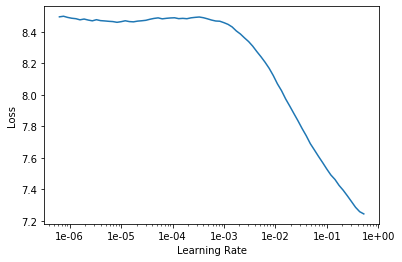

In [48]:
learn_lm.recorder.plot(skip_end=15)

In [50]:
learn_lm.fit_one_cycle(1, 7e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.103537,3.554966,0.371429,10:14


In [51]:
learn_lm.save('fit_head-JRC')

In [52]:
learn_lm.fit_one_cycle(1, 7e-2, moms=(0.8,0.7))
learn_lm.save('fit_head-JRC')

epoch,train_loss,valid_loss,accuracy,time
0,5.178988,3.479254,0.400000,10:17


In [ ]:
learn_lm.load('fit_head-JRC')

In [54]:
learn=learn_lm
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


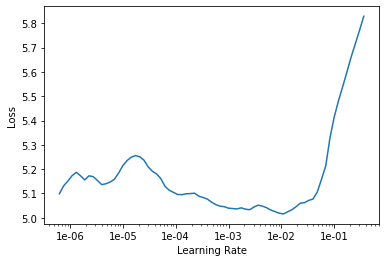

In [56]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [57]:
epochs = 7 # orig: 10
learn.fit_one_cycle(epochs, slice(1e-4, 1e-2) , moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.073738,3.027182,0.500000,11:44
1,4.257020,2.805593,0.557143,11:45
2,4.270291,2.601925,0.528571,11:44
3,3.743683,2.293327,0.614286,11:45
4,3.879797,2.395049,0.571429,11:45
5,3.729631,2.280197,0.600000,11:46
6,3.786686,2.232687,0.585714,11:45


In [58]:
learn.save('fine_tuned-JRC')

In [59]:

learn.load('fine_tuned-JRC');

Finetuning is finished. We reach an accuracy of around 60% in predicting the next word. This is only possible because we have restricted domain and heavily preprocessed text.

Let's see what kind of language can be generated now:

In [60]:
# test lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


The European Commission < legalact > < date > application < reference > ec treaty state aid enterprise production processing marketing product commission < legalact > application < reference > ec treaty state aid enterprise production processing marketing product commission regard treaty community
The European Commission < legalact > < date > application < reference > ec treaty state aid enterprise production processing marketing product commission regard treaty community subparagraph < reference > agreement area < reference > thereof regard council < legalact > < date
The European Commission request accordance < reference > council < legalact > < date > provision implementation council < legalact > community custom code implement rule measure community custom duty chapter < reference > council < legalact > < date > < legalact
The European Commission contribution proveniente kingdom share amount < date > < reference > a < legalact > community measure < reference > council < legalact > 

Yes, this looks very much like the text in the preprocessed documents, so it looks like LM finetuning did a good job.

In [61]:
learn.save_encoder('fine_tuned_enc-JRC')


## 3. Train a classifier

Now let's go start with the most important part, the training of the classifier itself.

This includes:
* Defining proper metrics (although in later research we used additional metrics like RP@K and nDCG@K as well)
* Create a `DataBunch`
* Create a classifier learner
* Train the classifier
* Evaluate the results


As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

The use `partial` functions to have different (probility) thresholds used in the metrics.

In [3]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [8]:
## make small subsample in order to train faster
df = pd.read_csv(FN)
df = df[['text','labels']]
df.head(2)


,text,labels
0,commission community com proposal <legalact> p...,5498;3115;4511;4509;4515
1,parliament council <date> concern post worker ...,1424;557;1946;3005;5206;82


Now we create the `DataBunch` and label it with the EuroVoc labels in `labels` column

In [65]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [66]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '>', '<', 'date', 'legalact', 'reference', 'state', 'commission', 'member', 'community', 'product', 'council']


In [4]:
data_clas = load_data(Path('.'), 'data_clas.pkl', bs=bs)

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.BCEWithLogitsLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [10]:
data_clas.show_batch()
#data_clas.label_list


text,target
xxbos section commission content volume section commission title surplus title revenue person work institution community body revenue operation institution title contribution refund connection community agreement programme interest payment title borrow lending operation revenue title xx expenditure allocate policy area chapter xx expenditure allocate policy area title affair chapter expenditure affair policy area chapter union chapter affair chapter operation instrument title enterprise chapter expenditure enterprise policy area chapter policy innovation chapter,5158;933
xxbos commission < legalact > < date > list product council < legalact > commission community treaty community council < legalact > < date > establishment community survey production < reference > thereof whereas member state community survey production survey production product production survey list product permit production trade afford comparison community product nomenclature list product refer list member state order compare datum member state prodcom list measure accordance opinion,2720;3634;4258
xxbos council < legalact > < date > < legalact > community regime control export item technology council union regard treaty community < reference > thereof regard proposal commission < legalact > dualuse item control export community order member state community commitment list dualuse item technology < legalact > implement dualuse control arrangement missile technology control regime supplier group chemical weapon convention < reference > < legalact > conformity obligation,3156;4496;5461;5542
xxbos < date > < legalact > safety rule passenger commission community treaty community < legalact > < date > safety rule passenger ship < reference > point thereof convention safety life code resolution safety rule passenger vessel force date adoption < legalact > amendment sola convention code resolution enter force date adoption < legalact > force instrument annex < legalact > < legalact > accordance opinion committee < reference,2141;3641;4033;4511;4522;5234;5889
xxbos commission < legalact > < date > rule application council < legalact > regard support scheme title iv iva < legalact > use land production material content chapter scope provision chapter quality premium durum wheat chapter protein crop premium chapter payment rice chapter area payment chapter aid starch potato chapter dairy premium payment chapter aid energy crop section definition section contract section amendment termination contract section yield quantity deliver,1521;1839;2443;2734;3003;4630


Next is the definition of the `text_classifier_learner`, which has the following inputs:
* our databunch of JRC documents with labels
* the original `AWD_LSTM` model trained on Wikipedia which we will finetune
* the metrics we defined

In [5]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-JRC')


In [68]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of CrossEntropyLoss()
CrossEntropyLoss()


And now we start with the training process. As typical with fastAI (and as already used in LM finetuning) we apply **gradual unfreezing** of the model in order to achieve good performance.

In [6]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


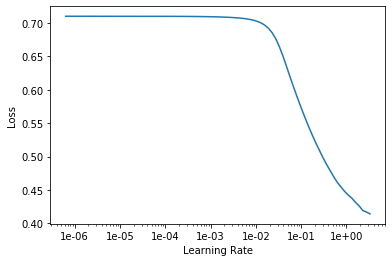

In [7]:
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(2, slice(1e-1,1e-1), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.008956,0.007960,0.998489,0.798779,0.575997,0.134103,0.016536,0.968290,0.577009,0.132946,0.074118,0.994093,0.583700,0.130499,0.191015,0.996835,0.594479,0.128274,0.237532,0.998016,0.612785,0.122177,0.253629,0.998342,0.623342,0.116139,0.242006,0.998437,0.641723,0.111522,0.200848,0.998489,0.653018,0.107042,0.179001,04:34
1,0.006474,0.005552,0.998649,0.889872,0.700230,0.246444,0.032466,0.982289,0.702339,0.245488,0.147232,0.995690,0.706342,0.241295,0.335979,0.997497,0.712851,0.236297,0.398561,0.998314,0.728246,0.226033,0.404115,0.998538,0.742610,0.217597,0.374886,0.998622,0.756436,0.206153,0.344445,0.998649,0.768704,0.198049,0.312158,04:27


When only training the *added layers*, but with `AWD_LSTM` still frozen, we get to an F1=0.40 after 2 epochs.


In [9]:
learn.save('first-2nd')

In [10]:
learn.load('first-2nd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14016 items)
x: TextList
xxbos parliament council < date > concern post worker framework provision service parliament council union regard treaty community < reference > thereof regard proposal commission opinion committee act accordance procedure < reference > b treaty whereas < reference > treaty abolition member state obstacle movement person service community provision service restriction base nationality residence requirement prohibit treaty effect end period completion market environment provision service prompt number undertaking post employee work member state whereas provision service form performance work account direction contract party service hireout worker use framework contract promotion provision service climate competition measure guarantee respect worker whereas employment relationship raise problem regard legislation employment relationship interest party term condition employment relationship envisage convention 

Why gradual unfreeze? Give example of Image detection.

In [11]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


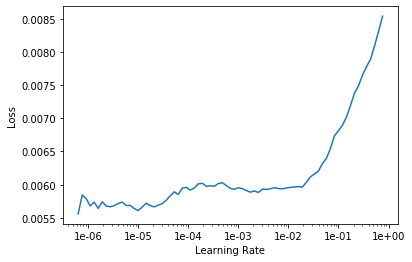

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(3, slice(3e-3/(2.6**4),3e-3), moms=(0.8,0.7))
learn.fit_one_cycle(4, slice(3e-3/(2.6**4),3e-3), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.006345,0.005796,0.998620,0.883036,0.748398,0.187214,0.032213,0.982328,0.749099,0.186415,0.142593,0.996026,0.753927,0.182528,0.330548,0.997719,0.758884,0.178522,0.383229,0.998420,0.769127,0.170810,0.374825,0.998574,0.780971,0.160266,0.336949,0.998617,0.790944,0.152281,0.295463,0.998620,0.804947,0.145949,0.254929,04:44
1,0.005947,0.005486,0.998641,0.897650,0.714017,0.234304,0.037027,0.983652,0.714114,0.233524,0.157240,0.996101,0.718220,0.230221,0.353053,0.997700,0.724296,0.226561,0.414141,0.998402,0.736350,0.217340,0.407442,0.998582,0.747000,0.208367,0.374226,0.998632,0.757499,0.201154,0.333189,0.998641,0.766879,0.192388,0.297593,04:39
2,0.005623,0.005219,0.998684,0.908133,0.752877,0.250786,0.040252,0.985071,0.755736,0.249962,0.168753,0.996373,0.762261,0.246131,0.370042,0.997835,0.770063,0.241242,0.428487,0.998474,0.781582,0.232465,0.428245,0.998638,0.789504,0.223891,0.400602,0.998683,0.806633,0.214889,0.364058,0.998684,0.814618,0.206381,0.321963,04:39
3,0.005443,0.005178,0.998696,0.910416,0.749797,0.264366,0.041621,0.985184,0.751575,0.263582,0.173320,0.996345,0.756916,0.259414,0.371602,0.997833,0.763288,0.253525,0.435750,0.998462,0.777744,0.244294,0.434903,0.998633,0.792393,0.235841,0.407299,0.998691,0.803846,0.225789,0.374528,0.998696,0.812780,0.217263,0.335388,04:46


Training with one extra layer and 4 more epochs, we are at F1=0.44.

In [14]:
learn.save('second-2nd')

In [15]:
learn.load('second-2nd');

In [16]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


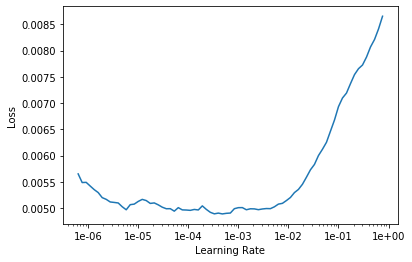

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.fit_one_cycle(4, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.005579,0.005263,0.998682,0.919422,0.707652,0.280782,0.053011,0.985020,0.708807,0.279771,0.187654,0.996005,0.714082,0.276079,0.364323,0.997640,0.722579,0.272041,0.422915,0.998375,0.736455,0.260951,0.430477,0.998581,0.747910,0.252095,0.408108,0.998658,0.755990,0.242773,0.379373,0.998682,0.765979,0.234354,0.344103,05:35
1,0.005730,0.004990,0.998726,0.915292,0.764097,0.273258,0.057987,0.985909,0.764651,0.272412,0.208050,0.996480,0.768339,0.268474,0.396913,0.997913,0.773449,0.264181,0.452118,0.998528,0.785425,0.254806,0.450225,0.998673,0.796320,0.246614,0.420136,0.998722,0.808186,0.237539,0.386858,0.998726,0.819301,0.228604,0.350341,05:22
2,0.005017,0.004696,0.998772,0.928495,0.764085,0.320230,0.065764,0.987039,0.764939,0.319176,0.224839,0.996546,0.769236,0.314233,0.412591,0.997905,0.777280,0.308358,0.478281,0.998538,0.787817,0.294190,0.495431,0.998712,0.802717,0.284127,0.474829,0.998768,0.814064,0.273502,0.442721,0.998772,0.825209,0.262714,0.403177,05:28
3,0.004883,0.004585,0.998789,0.931716,0.769967,0.332373,0.065413,0.987425,0.770930,0.330861,0.226116,0.996547,0.776884,0.327136,0.415515,0.997913,0.784133,0.321351,0.486412,0.998559,0.796474,0.309053,0.505532,0.998725,0.808963,0.296864,0.485272,0.998787,0.817719,0.286853,0.455397,0.998789,0.834707,0.273400,0.415439,05:25


### Results after unfreeze to -3:

4 more epochs and one more layer, **F1 is around 0.5** now.



In [19]:
learn.save('third-2nd')

In [ ]:
learn.load('third-2nd')

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


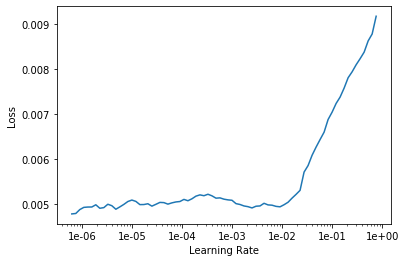

In [22]:
learn.lr_find()
learn.recorder.plot()

Now we are about to train the whole unfrozed model, choosing a LR is now a bit harder (see graph above).
We chose 1e-3.

In [23]:
#learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), wd=0.1) ## too much??? but in the end it comes in nicely ..
#learn.fit_one_cycle(15, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7)) ## works well
#learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.004835,0.004572,0.998793,0.937980,0.752292,0.351239,0.073579,0.987968,0.753624,0.350042,0.233138,0.996544,0.756453,0.346078,0.415182,0.997875,0.763087,0.340212,0.483360,0.998532,0.777954,0.326844,0.509422,0.998709,0.792546,0.315512,0.490526,0.998775,0.806518,0.304137,0.462065,0.998793,0.817038,0.293337,0.429567,06:09
1,0.004754,0.004534,0.998798,0.932981,0.759404,0.349708,0.072976,0.987204,0.760048,0.348442,0.229165,0.996418,0.767694,0.343626,0.416108,0.997834,0.773880,0.339042,0.486937,0.998527,0.784668,0.325923,0.515650,0.998712,0.799145,0.314218,0.496074,0.998779,0.812607,0.301122,0.465832,0.998798,0.821961,0.290452,0.431421,06:10
2,0.004773,0.004527,0.998799,0.940403,0.752023,0.357483,0.075842,0.988119,0.753137,0.356430,0.237616,0.996525,0.758017,0.350258,0.420560,0.997845,0.765178,0.345405,0.488379,0.998528,0.779390,0.333351,0.516261,0.998713,0.793925,0.321559,0.499519,0.998784,0.808225,0.311890,0.473482,0.998799,0.820407,0.300650,0.440425,06:12
3,0.004666,0.004520,0.998799,0.940903,0.760342,0.351883,0.084498,0.988574,0.761356,0.351027,0.246208,0.996692,0.764561,0.346109,0.430648,0.997956,0.768898,0.339984,0.495829,0.998573,0.780757,0.329595,0.517143,0.998740,0.793338,0.320211,0.497627,0.998788,0.806323,0.311750,0.465076,0.998799,0.813816,0.300891,0.432043,06:13
4,0.004693,0.004456,0.998811,0.943910,0.755842,0.364688,0.079925,0.988846,0.757285,0.363650,0.247883,0.996698,0.761926,0.359308,0.433721,0.997950,0.769953,0.351984,0.502324,0.998568,0.782403,0.342086,0.525266,0.998741,0.795736,0.330793,0.507858,0.998798,0.808713,0.319394,0.477471,0.998811,0.817672,0.309629,0.444415,06:07
5,0.004721,0.004407,0.998820,0.934547,0.753944,0.378023,0.079813,0.987137,0.754748,0.376941,0.238674,0.996327,0.760067,0.371547,0.423133,0.997799,0.767183,0.365870,0.496652,0.998539,0.779940,0.354885,0.531453,0.998733,0.790368,0.342532,0.517498,0.998808,0.802379,0.330482,0.493289,0.998820,0.815089,0.318964,0.456407,06:11
6,0.004591,0.004385,0.998818,0.938597,0.793801,0.346931,0.072968,0.988858,0.794033,0.345891,0.252848,0.996912,0.797283,0.341597,0.450291,0.998110,0.804133,0.337111,0.517756,0.998664,0.813545,0.325194,0.532336,0.998791,0.824767,0.314921,0.504475,0.998824,0.836047,0.303461,0.470797,0.998818,0.843615,0.294103,0.429567,06:18
7,0.004553,0.004317,0.998841,0.942402,0.761102,0.386988,0.091669,0.988484,0.762292,0.385363,0.253891,0.996605,0.768428,0.379817,0.440829,0.997901,0.776108,0.373832,0.507247,0.998572,0.788879,0.361650,0.541022,0.998758,0.800072,0.351005,0.528450,0.998821,0.812304,0.336858,0.502075,0.998841,0.825135,0.327144,0.469238,06:12


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We trained the unfrozed mode for 15 epochs. That's it. After that, let's look at the results!

## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [36]:
learn.load('postfinal-2nd')

# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()

In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [42]:
thresh = 0.24

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.571583979845982
P (micro) 0.6150576058160311
R (micro) 0.5338502673796791

F1 (macro) 0.16389456792961715
P (macro) 0.18558060004246557
R (macro)  0.1689372791808494


Our **Micro-F1 is now at about 0.57**!

In [44]:
f1_score(y_true, y_pred>thresh, average='macro')

0.05409356581589966

In [ ]:
y_true = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true.shape

In [23]:
metrics = classification_report(y_true, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
        1000       0.00      0.00      0.00         5
        1005       0.00      0.00      0.00        42
        1008       0.00      0.00      0.00         1
        1010       0.00      0.00      0.00         0
        1011       0.00      0.00      0.00         0
        1012       0.00      0.00      0.00         0
        1015       0.00      0.00      0.00         6
        1018       0.67      0.36      0.47        11
        1019       0.00      0.00      0.00        23
        1021       0.00      0.00      0.00        17
        1025       0.00      0.00      0.00         5
        1026       0.33      1.00      0.50         1
        1030       0.00      0.00      0.00         0
        1031       1.00      0.50      0.67        10
        1034       0.00      0.00      0.00         2
        1035       0.00      0.00      0.00         8
        1036       0.00    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Above, we can see the result per class. As expected, if a label is used often (high *support*), then classification accuracy tends to be much better then for few-shot or even zero-short labels.